Edges:
Classes:
Features:

Edges Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB

Classes Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB

Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15185 entries, 0 to 15184
Columns: 167 entries, 0 to 166
dtypes: float64(165), int64(2)
memory usage: 19.3 MB

Class Distribution:
class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64


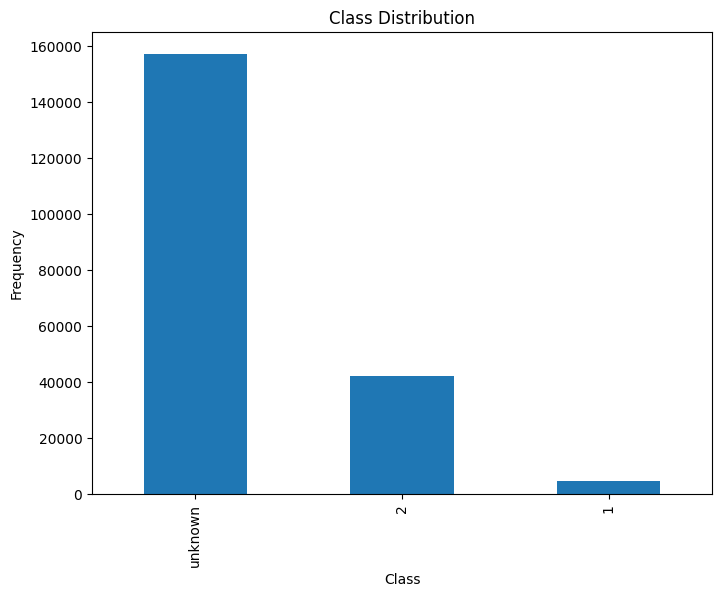

<ipython-input-22-5c836115ba09>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_edges['txId1'] = valid_edges['txId1'].map(tx_id_to_index)
<ipython-input-22-5c836115ba09>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_edges['txId2'] = valid_edges['txId2'].map(tx_id_to_index)


Epoch 000, Loss: nan, Validation Accuracy: 0.0013
Epoch 010, Loss: nan, Validation Accuracy: 0.0013
Epoch 020, Loss: nan, Validation Accuracy: 0.0013
Epoch 030, Loss: nan, Validation Accuracy: 0.0013
Epoch 040, Loss: nan, Validation Accuracy: 0.0013
Epoch 050, Loss: nan, Validation Accuracy: 0.0013
Epoch 060, Loss: nan, Validation Accuracy: 0.0013
Epoch 070, Loss: nan, Validation Accuracy: 0.0013
Epoch 080, Loss: nan, Validation Accuracy: 0.0013
Epoch 090, Loss: nan, Validation Accuracy: 0.0013
Epoch 100, Loss: nan, Validation Accuracy: 0.0013
Epoch 110, Loss: nan, Validation Accuracy: 0.0013
Epoch 120, Loss: nan, Validation Accuracy: 0.0013
Epoch 130, Loss: nan, Validation Accuracy: 0.0013
Epoch 140, Loss: nan, Validation Accuracy: 0.0013
Epoch 150, Loss: nan, Validation Accuracy: 0.0013
Epoch 160, Loss: nan, Validation Accuracy: 0.0013
Epoch 170, Loss: nan, Validation Accuracy: 0.0013
Epoch 180, Loss: nan, Validation Accuracy: 0.0013
Epoch 190, Loss: nan, Validation Accuracy: 0.0013


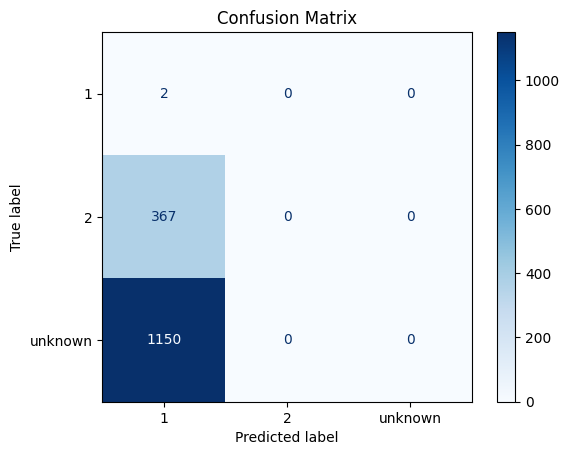

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.0013, Precision: 0.0000, Recall: 0.0013, F1: 0.0000


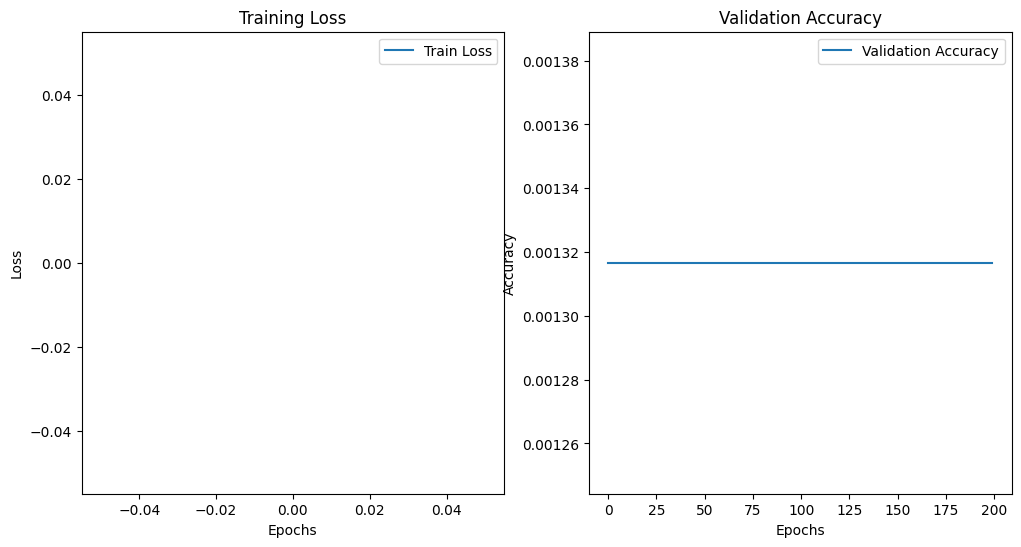

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
edges = pd.read_csv('elliptic_txs_edgelist.csv')
classes = pd.read_csv('elliptic_txs_classes.csv')
features = pd.read_csv('elliptic_txs_features.csv', header=None)
print("Edges:")
edges.head()
print("Classes:")
classes.head()
print("Features:")
features.head()

# Check the basic statistics and data types
print("\nEdges Info:")
edges.info()
edges.describe()

print("\nClasses Info:")
classes.info()
classes.describe()

print("\nFeatures Info:")
features.info()
features.describe()

# Check the distribution of classes
class_distribution = classes['class'].value_counts()
print("\nClass Distribution:")
print(class_distribution)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Create a mapping from transaction IDs to feature indices
tx_id_to_index = {tx_id: idx for idx, tx_id in enumerate(features[0])}

# Filter and map edges
valid_edges = edges[edges['txId1'].isin(tx_id_to_index) & edges['txId2'].isin(tx_id_to_index)]
valid_edges['txId1'] = valid_edges['txId1'].map(tx_id_to_index)
valid_edges['txId2'] = valid_edges['txId2'].map(tx_id_to_index)

# Convert to PyTorch tensor for edge indices
edge_index = torch.tensor(valid_edges.values.T, dtype=torch.long)

# Extract node features and ensure correct shape
node_features = torch.tensor(features.drop(columns=[0]).values, dtype=torch.float)

# Filter class labels to ensure they only correspond to valid nodes
node_indices = features[0].values
valid_classes = classes[classes['txId'].isin(node_indices)]

# Encode class labels
le = LabelEncoder()
class_labels = le.fit_transform(valid_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)

# Create the PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, y=node_labels)

# Create masks for training, validation, and testing
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)

train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)
test_size = num_nodes - train_size - val_size

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[perm[:train_size]] = True
data.val_mask[perm[train_size:train_size + val_size]] = True
data.test_mask[perm[train_size + val_size:]] = True

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Define the training function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the evaluation function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        accuracy = int(correct) / int(data.test_mask.sum())
    return accuracy

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    if epoch % 10 == 0:
        val_acc = evaluate(model, data)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Evaluate on the test set
test_accuracy = evaluate(model, data)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Define the prediction function
def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

# Predict on the test set
test_pred = predict(model, data)[data.test_mask]

# Generate the confusion matrix
cm = confusion_matrix(data.y[data.test_mask].cpu(), test_pred.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_recall_fscore_support

def evaluate_metrics(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        accuracy = (y_true == y_pred).sum() / len(y_true)

    return accuracy, precision, recall, f1

# After training, use:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_metrics(model, data)
print(f'Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    loss = train(model, data, optimizer, criterion)
    val_acc = evaluate(model, data)
    train_losses.append(loss)
    val_accuracies.append(val_acc)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
